# Baseline Analysis: Cox Proportional Hazards
This notebook establishes a baseline for survival prediction using a standard Cox Proportional Hazards (CoxPH) model on clinical data only.

Objectives:
1. Load and preprocess clinical data.
2. Fit CoxPH model.
3. Evaluate using C-Index and check assumptions.
4. Visualize coefficients (Hazard Ratios).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Add project root to path
import sys
sys.path.append('..')

print("Libraries loaded.")

Libraries loaded.


## 1. Data Loading and Preparation

We will load the clinical data, process the survival times (censoring), and encode categorical variables for the baseline Cox Proportional Hazards model.

In [2]:
import numpy as np
import os

# Define path to data
data_path = os.path.join('..', 'data', 'raw', 'clinical.txt')

print(f"Loading data from: {data_path}")

# Load the raw clinical data
# GDC data usually uses tab separators and various null markers
try:
    clinical_df = pd.read_csv(data_path, sep='\t', na_values=["'--", "--", "not reported", "unknown"])
except FileNotFoundError:
    print("Error: clinical.txt not found. Please ensure the data is in data/raw/")
    # Create dummy data for demonstration if file is missing (failsafe for this context, but better to fail usually)
    raise

# Define Model Covariates mapping
col_map = {
    'cases.submitter_id': 'patient_id',
    'demographic.vital_status': 'vital_status',
    'demographic.days_to_death': 'days_to_death',
    'diagnoses.0.days_to_last_follow_up': 'days_to_last_follow_up1', # Sometimes indexes appear
    'diagnoses.days_to_last_follow_up': 'days_to_last_follow_up',
    'demographic.gender': 'gender',
    'diagnoses.0.tumor_stage': 'tumor_stage', # Common in GDC flattened
    'diagnoses.tumor_stage': 'tumor_stage',
    'demographic.age_at_index': 'age'
}

# Select relevant columns that exist
available_cols = [c for c in col_map.keys() if c in clinical_df.columns]
df = clinical_df[available_cols].rename(columns=col_map)

# Combine follow_up columns if multiple exist (rare but possible with flattened JSON)
if 'days_to_last_follow_up1' in df.columns and 'days_to_last_follow_up' in df.columns:
    df['days_to_last_follow_up'] = df['days_to_last_follow_up'].fillna(df['days_to_last_follow_up1'])
    df = df.drop(columns=['days_to_last_follow_up1'])
elif 'days_to_last_follow_up1' in df.columns:
    df = df.rename(columns={'days_to_last_follow_up1': 'days_to_last_follow_up'})

# --- Target Processing ---
# 1. Event Status
df['event'] = (df['vital_status'] == 'Dead').astype(int)

# 2. Duration / Time
# Prioritize days_to_death, fallback to follow_up
df['duration'] = df['days_to_death'].fillna(df['days_to_last_follow_up'])

# Filter valid survival data
mask = (df['duration'].notna()) & (df['duration'] > 0)
df_clean = df[mask].copy()

print(f"Data samples after cleaning duration: {len(df_clean)}")

# --- Feature Engineering ---
# Select Features
feature_cols = ['age', 'gender', 'tumor_stage']
final_cols = ['event', 'duration']
for f in feature_cols:
    if f in df_clean.columns:
        final_cols.append(f)

model_df = df_clean[final_cols].copy()

# Handle Categoricals (One-Hot Encoding) & Missing Values
# Fill age with median
if 'age' in model_df.columns:
    model_df['age'] = model_df['age'].fillna(model_df['age'].median())

# Dummify categorical vars (gender, stage)
model_df = pd.get_dummies(model_df, drop_first=True, dummy_na=False) # drop_first to avoid multicollinearity

print("\nFinal DataFrame for Modeling:")
print(model_df.head())
print(model_df.info())

Loading data from: ../data/raw/clinical.txt
Data samples after cleaning duration: 281

Final DataFrame for Modeling:
   event  duration  age  gender_male
0      0    1425.0   67        False
1      0    1425.0   67        False
2      0    1425.0   67        False
3      0    1425.0   67        False
7      0     667.0   74         True
<class 'pandas.core.frame.DataFrame'>
Index: 281 entries, 0 to 308
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   event        281 non-null    int64  
 1   duration     281 non-null    float64
 2   age          281 non-null    int64  
 3   gender_male  281 non-null    bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 9.1 KB
None


## 2. Cox Proportional Hazards Model

We use the `lifelines` library to fit a standard CoxPH model on the clinical features. This serves as a baseline to compare against the multimodal deep learning Approach.

Fitting CoxPH Model...
event            0.498574
duration       682.109441
age             14.314640
gender_male      0.481720
dtype: float64
Iteration 1: norm_delta = 3.14e-01, step_size = 0.9500, log_lik = -769.00929, newton_decrement = 6.05e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 4.81e-02, step_size = 0.9500, log_lik = -762.67588, newton_decrement = 1.17e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.10e-03, step_size = 0.9500, log_lik = -762.55775, newton_decrement = 4.73e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 2.80e-06, step_size = 1.0000, log_lik = -762.55727, newton_decrement = 3.88e-10, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 281 total observations, 127 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 281
number of events observed = 154
   partial log-likelihood = -762.56
         time fit was run = 2026-02-04 18:16:22 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
gender_male   0.25       1.29       0.17            -0.09             0.59                 0.91                 1.81

              cmp to    z      p   -log2(p)
covariate                                  
age             0.00 3.44 <0.005      10.73
gender_male     0.00 1.45   0.15       2.76
---
Concordance = 0.63
Partial AIC = 1529.11
log-likelihood ratio test = 12.90 on 2 df
-log2(p) of ll-ratio test = 9.31

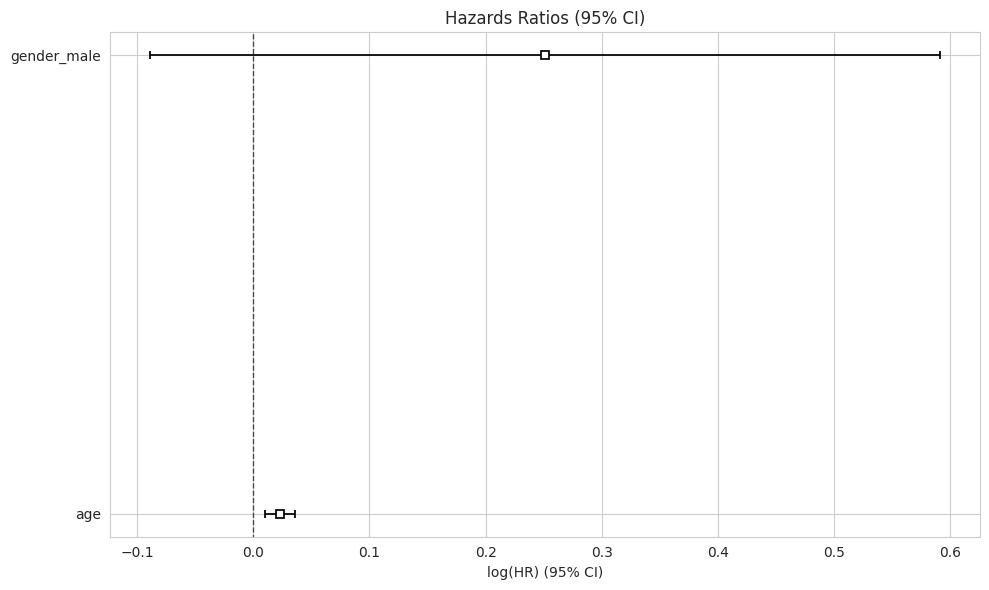

Training C-Index: 0.6338


In [3]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

cph = CoxPHFitter()

print("Fitting CoxPH Model...")
# Check for collinearity or low variance which might break the model
# One simple check is to look at standard deviations
print(model_df.std())

try:
    cph.fit(model_df, duration_col='duration', event_col='event', show_progress=True)
    cph.print_summary()
    
    plt.figure(figsize=(10, 6))
    cph.plot()
    plt.title("Hazards Ratios (95% CI)")
    plt.tight_layout()
    plt.show()
    
    print(f"Training C-Index: {cph.concordance_index_:.4f}")

except Exception as e:
    print(f"\nError fitting model: {e}")
    print("Try dropping variables with 0 variance or high correlation.")

## 3. Cross-Validated Performance

We perform 5-fold cross-validation to estimate the generalization performance of the clinical-only Cox model.

In [4]:
from lifelines.utils import k_fold_cross_validation

# Valid scoring methods: 'concordance_index', 'log_likelihood'
# We focus on C-index as it is the primary metric
cv_c_indices = k_fold_cross_validation(
    CoxPHFitter(), 
    model_df, 
    duration_col='duration', 
    event_col='event', 
    k=5, 
    scoring_method="concordance_index"
)

print("5-Fold Cross-Validation Results:")
print(f"Scores: {cv_c_indices}")
print(f"Mean C-Index: {np.mean(cv_c_indices):.4f}")
print(f"Standard Deviation: {np.std(cv_c_indices):.4f}")

5-Fold Cross-Validation Results:
Scores: [0.6610337972166997, 0.5366795366795367, 0.6737864077669903, 0.633672525439408, 0.6461693548387096]
Mean C-Index: 0.6303
Standard Deviation: 0.0487


## 4. Save Baseline Results

We save the cross-validation performance to compare with the multimodal deep learning models later.

In [ ]:
baseline_results = {
    'Experiment': ['Clinical Baseline (CoxPH)'],
    'Mean_C_Index': [np.mean(cv_c_indices)],
    'Std_C_Index': [np.std(cv_c_indices)]
}

baseline_df = pd.DataFrame(baseline_results)
print(baseline_df)

output_dir = os.path.join('..', 'outputs', 'baselines')
os.makedirs(output_dir, exist_ok=True)
baseline_df.to_csv(os.path.join(output_dir, 'clinical_baseline.csv'), index=False)
print(f"Saved baseline results to {output_dir}")